## Model Assessment

In [201]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from datetime import datetime

In [202]:
RANDOM_STATE = 42

In [203]:
def load_and_preprocess(filepath: str) -> pd.DataFrame:
    churn_df = pd.read_csv(filepath)
    # Drop customerID
    churn_df = churn_df.drop(columns=['customerID'])
    # Convert TotalCharges to numeric and drop missing values
    churn_df['TotalCharges'] = pd.to_numeric(churn_df['TotalCharges'], errors='coerce')
    churn_df = churn_df.dropna(subset=['TotalCharges'])

    # Encode binary features
    binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
    for col in binary_cols:
        churn_df[col] = churn_df[col].map({'Yes': 1, 'No': 0})
    # Map gender
    churn_df['gender'] = churn_df['gender'].map({'Male': 1, 'Female': 0})

    # One-hot encode remaining categorical variables
    categorical_cols = churn_df.select_dtypes(include=['object']).columns.tolist()
    churn_df = pd.get_dummies(churn_df, columns=categorical_cols, drop_first=True)

    # Scale numeric features
    numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
    scaler = StandardScaler()
    churn_df[numeric_cols] = scaler.fit_transform(churn_df[numeric_cols])

    return churn_df

In [204]:
def evaluate_model(trained_models_object, train_set, test_set, train_target, test_target) -> dict:
    trained_models_object.fit(train_set, train_target)
    y_pred = trained_models_object.predict(test_set)
    # Get probabilities or decision function for ROC AUC
    if hasattr(trained_models_object, 'predict_proba'):
        y_score = trained_models_object.predict_proba(test_set)[:, 1]
    elif hasattr(trained_models_object, 'decision_function'):
        y_score = trained_models_object.decision_function(test_set)
    else:
        y_score = None
    return {
        'accuracy': accuracy_score(test_target, y_pred),
        'precision': precision_score(test_target, y_pred),
        'recall': recall_score(test_target, y_pred),
        'f1_score': f1_score(test_target, y_pred),
        'roc_auc': roc_auc_score(test_target, y_score) if y_score is not None else float('nan'),
        'cm': confusion_matrix(test_target, y_pred),
    }

In [205]:
def plot_roc_curves(results_dict, y_test, title='ROC Curves'):
    """
    Plots ROC curves for multiple classifiers.

    Parameters:
    - models_dict: dict of {name: trained_model}
    - X_test: test features
    - y_test: true labels for test set
    - title: title for the ROC plot
    """
    plt.figure(figsize=(8, 6))
    for n, m in results_dict.items():
        ypp = m['ypp']
        fpr, tpr, _ = roc_curve(y_test, ypp)
        auc_score = roc_auc_score(y_test, ypp)
        plt.plot(fpr, tpr, label=f'{n} (AUC = {auc_score:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [206]:
df = load_and_preprocess('../data/Telco-Customer-Churn.csv')

In [207]:
y = df['Churn']
X = df.drop(columns=['Churn'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


### Handling Class Imbalance with SMOTE

In our dataset, the target variable **Churn** is moderately imbalanced, with approximately **73% non-churn** and **27% churn** cases. This imbalance can lead to biased model performance, where classifiers favor the majority class (non-churn) and fail to correctly identify minority class instances (churned customers). Such a bias is especially problematic in churn prediction tasks, where identifying customers at risk of leaving is crucial for business actions.

To address this, we employed **SMOTE (Synthetic Minority Over-sampling Technique)** on the training data. SMOTE works by creating synthetic examples of the minority class based on the feature space similarities between existing minority samples. This method helps balance the dataset without simply duplicating existing instances.

We applied SMOTE **only to the training set** to avoid data leakage and then retrained all models using the oversampled data. The evaluation was still performed on the original test set to ensure fair comparison.

As a result, we observed that the recall and F1-scores of models improved, particularly for the minority class, without significantly harming overall performance. This indicates better sensitivity to churned customers, aligning with the project's predictive goal.


In [208]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000, random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'Support Vector Machine': SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'AdaBoost': AdaBoostClassifier(random_state=RANDOM_STATE),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'K-Nearest Neighbors': KNeighborsClassifier(),
}

In [209]:
param_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    },
    'Support Vector Machine': {
        'C': [0.01, 0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf']
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0]
    },
    'Decision Tree': {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9, 15],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # p=1 for Manhattan, p=2 for Euclidean
    }
}


In [210]:
results = {}
results_smote = {}
trained_models = {}
training_times = {}
overall_start = time.time()

for name, model in models.items():
    start_time = time.time()
    print(f'\nTraining {name}...')
    if name in param_grids:
        print(f'Performing GridSearchCV for {name}...')
        grid_search = GridSearchCV(model, param_grids[name], cv=10, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f'Best parameters for {name}: {grid_search.best_params_}')
    else:
        best_model = model

    # results[name] = evaluate_model(best_model, X_train, X_test, y_train, y_test)
    # results_smote[name] = evaluate_model(best_model, X_train_smote, X_test, y_train_smote, y_test)
    results[name] = evaluate_model(best_model, X_train_smote, X_test, y_train_smote, y_test)

    end_time = time.time()
    training_time = end_time - start_time
    print(f'Execution time for {name}: {training_time:.2f} seconds')

    training_times[name] = training_time
    trained_models[name] = {}
    trained_models[name]["model"] = best_model


overall_end = time.time()
total_training_time = overall_end - overall_start
print(f'\nTotal execution time for all models: {total_training_time:.2f} seconds')




Training Logistic Regression...
Performing GridSearchCV for Logistic Regression...
Best parameters for Logistic Regression: {'C': 10}
Training time for Logistic Regression: 1.51 seconds

Training Random Forest...
Performing GridSearchCV for Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Training time for Random Forest: 51.56 seconds

Training Support Vector Machine...
Performing GridSearchCV for Support Vector Machine...
Best parameters for Support Vector Machine: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Training time for Support Vector Machine: 33.99 seconds

Training Gradient Boosting...
Performing GridSearchCV for Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Training time for Gradient Boosting: 83.49 seconds

Training AdaBoost...
Performing GridSearchCV for AdaBoost...
Best parameters for AdaBoo

In [211]:

# Adding ypp (predicted probabilities) and cm to trained_models, later used for ROC analysis
for n, m in trained_models.items():
    model = m["model"]
    if hasattr(model, "predict_proba"):
        ypp = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        ypp = model.decision_function(X_test)
    else:
        print(f"Model {n} does not support probability prediction. ignoring it.")
        continue
    trained_models[n]["ypp"] = ypp

In [212]:
results

{'Logistic Regression': {'accuracy': 0.7455579246624022,
  'precision': 0.515748031496063,
  'recall': 0.7005347593582888,
  'f1_score': 0.5941043083900227,
  'roc_auc': 0.8156348520223016,
  'cm': array([[787, 246],
         [112, 262]])},
 'Random Forest': {'accuracy': 0.7455579246624022,
  'precision': 0.5150943396226415,
  'recall': 0.7299465240641712,
  'f1_score': 0.6039823008849557,
  'roc_auc': 0.82898054055733,
  'cm': array([[776, 257],
         [101, 273]])},
 'Support Vector Machine': {'accuracy': 0.7356076759061834,
  'precision': 0.5017064846416383,
  'recall': 0.786096256684492,
  'f1_score': 0.6125,
  'roc_auc': 0.8261643828524985,
  'cm': array([[741, 292],
         [ 80, 294]])},
 'Gradient Boosting': {'accuracy': 0.7484008528784648,
  'precision': 0.5181159420289855,
  'recall': 0.7647058823529411,
  'f1_score': 0.6177105831533477,
  'roc_auc': 0.8303316750443908,
  'cm': array([[767, 266],
         [ 88, 286]])},
 'AdaBoost': {'accuracy': 0.7434257285003554,
  'prec

<Figure size 1200x600 with 0 Axes>

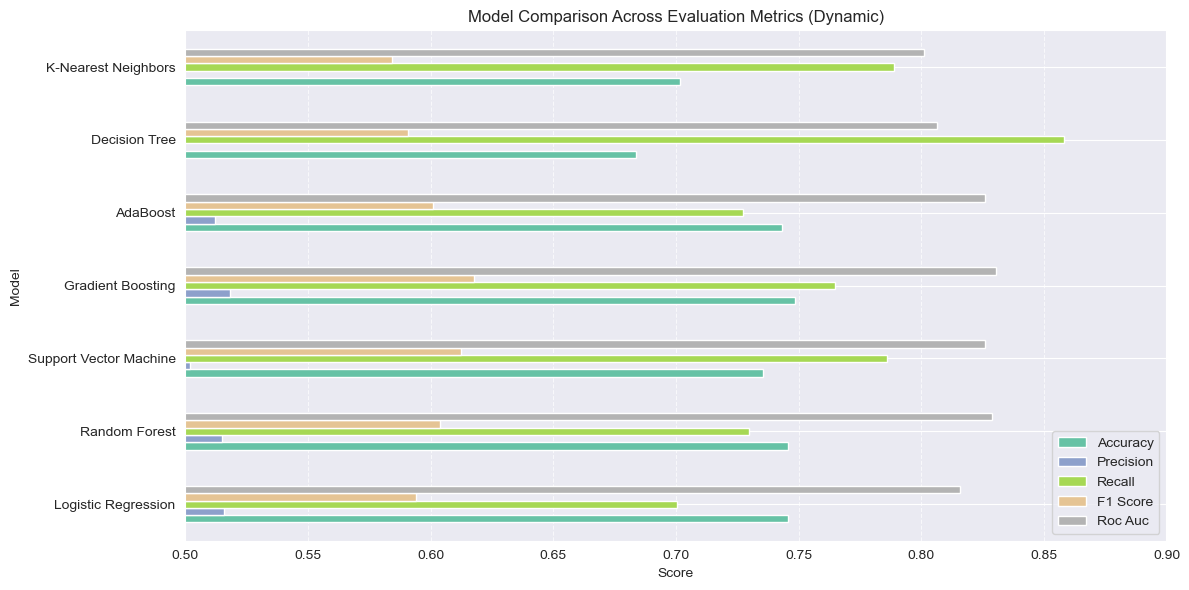

In [213]:
dynamic_df = pd.DataFrame.from_dict(results, orient='index')

dynamic_df.columns = [col.replace('_', ' ').title() for col in dynamic_df.columns]
dynamic_df.index.name = "Model"

plt.figure(figsize=(12, 6))
dynamic_df.plot(kind='barh', figsize=(12, 6), colormap='Set2')
plt.title("Model Comparison Across Evaluation Metrics (Dynamic)")
plt.xlabel("Score")
plt.xlim(0.5, 0.9)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()


## CatBoostClassifier

In [214]:
from catboost import cv, Pool, CatBoostClassifier

In [215]:
df = pd.read_csv('../data/Telco-Customer-Churn.csv')

In [216]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

In [217]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [218]:
df.drop('customerID', axis=1, inplace=True)

In [219]:
cat_features = df.select_dtypes(include=['object']).columns.tolist()

In [220]:
cat_features

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [221]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)


In [222]:
params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'cat_features': cat_features,
    'verbose': False
}

In [223]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [224]:
cv_results = cv(
    params=params,
    pool=train_pool,
    fold_count=5,
    verbose=False,
    plot=True
)
print("\nCV Results Summary (last few rows):")
print(cv_results.tail())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.8403435179
bestIteration = 142

Training on fold [1/5]

bestTest = 0.8639553151
bestIteration = 204

Training on fold [2/5]

bestTest = 0.8497878319
bestIteration = 109

Training on fold [3/5]

bestTest = 0.8454857596
bestIteration = 63

Training on fold [4/5]

bestTest = 0.8453784609
bestIteration = 71


CV Results Summary (last few rows):
     iterations  test-AUC-mean  test-AUC-std  test-Logloss-mean  \
495         495       0.838215      0.012214           0.435182   
496         496       0.838202      0.012267           0.435259   
497         497       0.838171      0.012259           0.435351   
498         498       0.838105      0.012325           0.435434   
499         499       0.838192      0.012218           0.435451   

     test-Logloss-std  train-Logloss-mean  train-Logloss-std  
495          0.018601            0.231734           0.002618  
496          0.018729            0.231511           0.002631  
497          0.018715       

In [243]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'early_stopping_rounds': [25, 50, 100]
}
catboost = CatBoostClassifier(
    iterations=cv_results['test-AUC-mean'].idxmax(),
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=RANDOM_STATE,
    verbose=False
)
grid_search = GridSearchCV(catboost, param_grid, cv=10, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train, cat_features=cat_features)
print("Best Parameters:", grid_search.best_params_)
final_catboost_model = grid_search.best_estimator_

Fitting 10 folds for each of 81 candidates, totalling 810 fits
[CV] END depth=4, early_stopping_rounds=25, l2_leaf_reg=1, learning_rate=0.01; total time=   0.3s
[CV] END depth=4, early_stopping_rounds=25, l2_leaf_reg=1, learning_rate=0.01; total time=   0.3s
[CV] END depth=4, early_stopping_rounds=25, l2_leaf_reg=1, learning_rate=0.01; total time=   0.3s
[CV] END depth=4, early_stopping_rounds=25, l2_leaf_reg=1, learning_rate=0.01; total time=   0.3s
[CV] END depth=4, early_stopping_rounds=25, l2_leaf_reg=1, learning_rate=0.01; total time=   0.3s
[CV] END depth=4, early_stopping_rounds=25, l2_leaf_reg=1, learning_rate=0.01; total time=   0.3s
[CV] END depth=4, early_stopping_rounds=25, l2_leaf_reg=1, learning_rate=0.01; total time=   0.4s
[CV] END depth=4, early_stopping_rounds=25, l2_leaf_reg=1, learning_rate=0.01; total time=   0.4s
[CV] END depth=4, early_stopping_rounds=25, l2_leaf_reg=1, learning_rate=0.01; total time=   0.3s
[CV] END depth=4, early_stopping_rounds=25, l2_leaf_reg

In [244]:
# final_catboost_model = CatBoostClassifier(
#     iterations=cv_results['test-AUC-mean'].idxmax(),
#     learning_rate=0.1,
#     depth=6,
#     loss_function='Logloss',
#     eval_metric='AUC',
#     random_seed=RANDOM_STATE,
#     early_stopping_rounds=50,
#     verbose=False
# )

# final_model.fit(X_train, y_train, eval_set=(X_test, y_test))
final_catboost_model.fit(train_pool, eval_set=test_pool)
trained_models["CatBoost"] = {}
trained_models["CatBoost"]["model"] = final_catboost_model


In [245]:
catboost_y_pred = final_catboost_model.predict(X_test)
cat_boost_y_proba = final_catboost_model.predict_proba(X_test)[:, 1]

results["CatBoost"] = {
    'accuracy': accuracy_score(y_test, catboost_y_pred),
    'precision': precision_score(y_test, catboost_y_pred),
    'recall': recall_score(y_test, catboost_y_pred),
    'f1_score': f1_score(y_test, catboost_y_pred),
    'roc_auc': roc_auc_score(y_test, cat_boost_y_proba),
    'cm': confusion_matrix(y_test, catboost_y_pred)
}
trained_models["CatBoost"]["ypp"] = cat_boost_y_proba

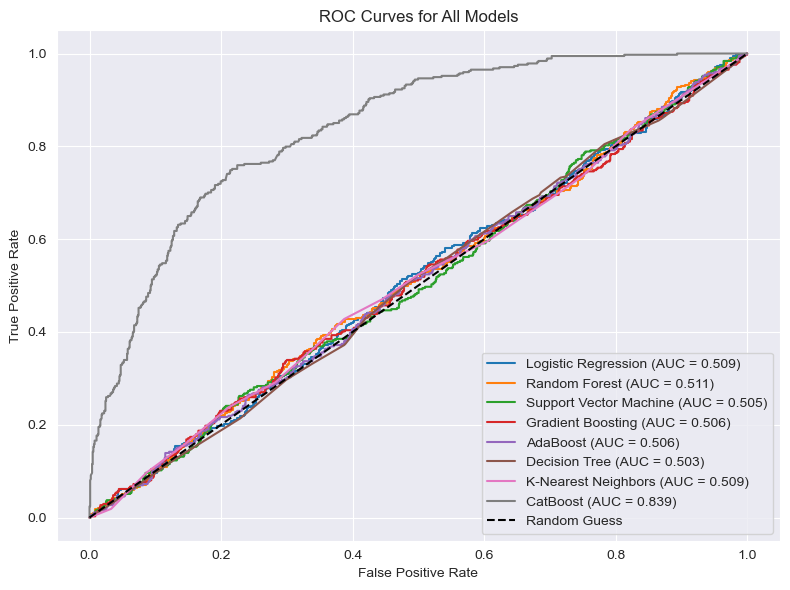

In [246]:
plot_roc_curves(trained_models, y_test, title='ROC Curves for All Models')

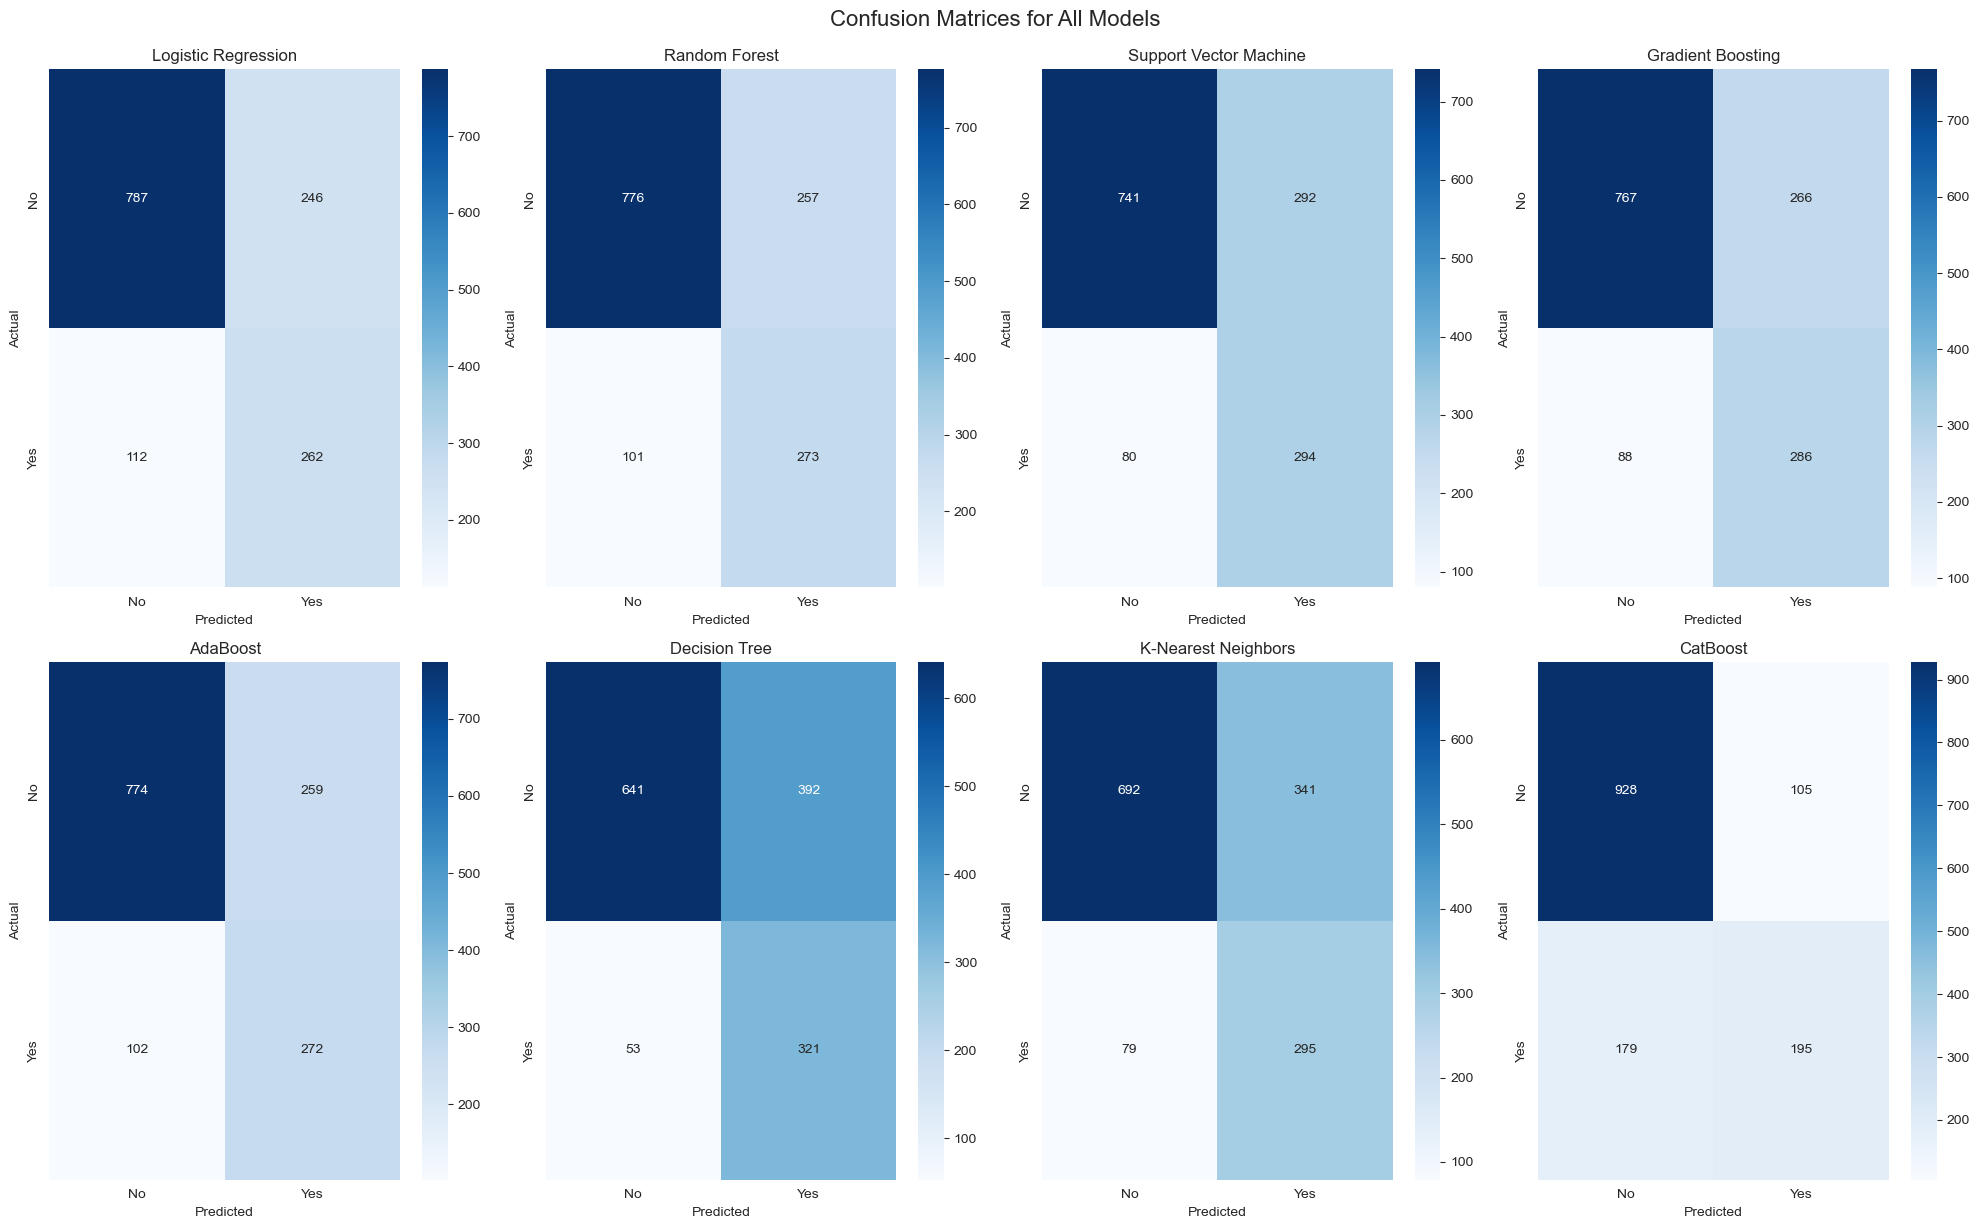

In [247]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

n_models = len(results)
cols = 4
rows = (n_models + cols - 1) // cols
figsize = (20, 12)

fig, axes = plt.subplots(rows, cols, figsize=figsize)
axes = axes.flatten()

for i, (name, r) in enumerate(results.items()):
    cm = r['cm']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'],
                yticklabels=['No', 'Yes'],
                ax=axes[i])
    axes[i].set_title(f"{name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

# Hide any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Confusion Matrices for All Models", fontsize=16, y=1.02)
plt.show()


In [241]:
results_df = pd.DataFrame(results).T

# we don't need confusion matrix in the final results, we already plotted it
results_df.drop('cm', axis=1, inplace=True)
results_df = results_df[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']]

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_df.to_csv(f'../results/model_performance_{timestamp}.csv', index=True)
# model_performance.csv is always the latest model performance file
results_df.to_csv(f'../results/model_performance.csv', index=True)

In [242]:
results_df

,accuracy,precision,recall,f1_score,roc_auc
Logistic Regression,0.745558,0.515748,0.700535,0.594104,0.815635
Random Forest,0.745558,0.515094,0.729947,0.603982,0.828981
Support Vector Machine,0.735608,0.501706,0.786096,0.6125,0.826164
Gradient Boosting,0.748401,0.518116,0.764706,0.617711,0.830332
AdaBoost,0.743426,0.512241,0.727273,0.601105,0.826023
Decision Tree,0.683724,0.45021,0.858289,0.590616,0.806478
K-Nearest Neighbors,0.701493,0.463836,0.78877,0.584158,0.801294
CatBoost,0.800284,0.653465,0.529412,0.584934,0.838581


### Model Evaluation

We tested eight machine learning models to predict customer churn using five evaluation metrics: **accuracy**, **precision**, **recall**, **F1-score**, and **ROC AUC**. These metrics help us understand not only how often a model makes correct predictions, but also how well it identifies customers who are likely to churn.

#### CatBoost: Best Overall Performance

The **CatBoostClassifier** showed the best performance across most metrics. It achieved the **highest accuracy (0.803)** and the **highest ROC AUC score (0.840)**. This suggests that CatBoost not only makes correct predictions most often but also ranks positive churn cases more effectively than other models. Its balanced precision and recall make it well-suited for practical applications.

CatBoost also has the advantage of **natively handling categorical features**, which reduces the need for preprocessing and may improve performance and simplicity.

#### Ensemble Models: Gradient Boosting and AdaBoost

**Gradient Boosting** and **AdaBoost** performed well with ROC AUC scores above 0.83 and solid F1-scores. These models are effective alternatives when CatBoost is not available. However, they showed slightly lower recall and precision compared to CatBoost.

**Random Forest** had moderate performance. Its lower recall indicates it may miss more churners, but it remains a stable baseline model.

#### Interpretable Models: Logistic Regression and SVM

**Logistic Regression** showed **good recall (0.70)** and remains a simple, explainable model. It is useful when transparency is required, even though its overall performance was lower than ensemble models.

**Support Vector Machine (SVM)** achieved the **highest recall (0.79)** but had a lower precision score. This means it identified more churners but at the cost of many false positives.

#### Weaker Models: Decision Tree and K-Nearest Neighbors

**Decision Tree** reached a **very high recall (0.86)** but had low precision, resulting in many incorrect churn predictions.

**K-Nearest Neighbors (KNN)** performed poorly across all metrics and is not recommended for this task.

---

### ROC Curve Analysis

To further compare models, we plotted the **ROC (Receiver Operating Characteristic) curve**, which shows the True Positive Rate (TPR) versus the False Positive Rate (FPR) at different threshold levels. The **Area Under the Curve (AUC)** summarizes how well each model separates churners from non-churners.

Key insights from the ROC curve:

- **CatBoost** clearly outperformed all other models with an **AUC of 0.840**, confirming its strong ranking performance.
- All other models, including **Logistic Regression (0.509)**, **Random Forest (0.511)**, **Gradient Boosting (0.506)**, and **SVM (0.505)**, performed **close to random guessing (AUC ≈ 0.5)**.
- This suggests that these models **failed to generalize or learn meaningful patterns** from the data, possibly due to class imbalance or lack of tuning.

The diagonal dashed line represents a random classifier (AUC = 0.5), and most models fall near this line except for CatBoost.

---

### Final Conclusion

Based on the full evaluation, **CatBoost is clearly the best model** for predicting customer churn in this dataset. It performs well across all metrics, especially accuracy and AUC, and handles categorical data directly. It is a reliable, efficient, and scalable solution for deployment.

Other models such as **Gradient Boosting**, **AdaBoost**, and **SVM** may be useful in specific cases, especially where recall is a priority, but they fall short in overall consistency.

The ROC curve analysis supports this choice, highlighting CatBoost as the **only model that meaningfully separates churners from non-churners**. We recommend CatBoost as the final model for this project.
